# The problem statement

_The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store._

_Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales._



# Hypotheses

### Store Level Hypotheses:

1. City type: Stores located in urban or Tier 1 cities should have higher sales because of the higher income levels of people there.
2. Population Density: Stores located in densely populated areas should have higher sales because of more demand.
3. Store Capacity: Stores which are very big in size should have higher sales as they act like one-stop-shops and people would prefer getting everything from one place
4. Competitors: Stores having similar establishments nearby should have less sales because of more competition.
5. Marketing: Stores which have a good marketing division should have higher sales as it will be able to attract customers through the right offers and advertising.
6. Location: Stores located within popular marketplaces should have higher sales because of better access to customers.
7. Customer Behavior: Stores keeping the right set of products to meet the local needs of customers will have higher sales.
8. Ambiance: Stores which are well-maintained and managed by polite and humble people are expected to have higher footfall and thus higher sales.

### Product Level Hypotheses:
1. Brand: Branded products should have higher sales because of higher trust in the customer.
2. Packaging: Products with good packaging can attract customers and sell more.
3. Utility: Daily use products should have a higher tendency to sell as compared to the specific use products.
4. Display Area: Products which are given bigger shelves in the store are likely to catch attention first and sell more.
5. Visibility in Store: The location of product in a store will impact sales. Ones which are right at entrance will catch the eye of customer first rather than the ones in back.
6. Advertising: Better advertising of products in the store will should higher sales in most cases.
7. Promotional Offers: Products accompanied with attractive offers and discounts will sell more.

# Data Explorative Analysis

In [61]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [62]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# check missing values
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [64]:
# check basics about numeric vars
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


1. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

In [65]:
# check unique values in each variables
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

This tells us that there are 1559 products and 10 outlets/stores. Also there are 16 unique item types.

In [66]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

1. Some 'Low Fat' values were mislabeled as 'low fat' and 'LF', also some 'Regular' as 'regular'.
2. Item_type, could be better to combine them have substeantial numbers.
3. Outlet_type, check if we can combine type 2 and type 3.

# Data Cleaning

## Imputing Missing Values

In [67]:
# Determine the average weight per item
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight Values
miss_bool = data['Item_Weight'].isnull()

#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [68]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each outlet type
outlet_size_mode = data.pivot_table(values='Outlet_Size', index='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode.loc[x])
print(sum(data['Outlet_Size'].isnull()))

C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Mode for each Outlet_Type:
                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium

Orignal #missing: 4016
0


## Feature Engineering

In [69]:
# considering item visiblity is unlikely to be 0, so treat as missing values
# Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

# Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [70]:
# Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [71]:
# Use first 2 letter to get a broad category
# Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
# Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [72]:
# Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [73]:
# Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [74]:
# Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [75]:
# convert categorical values to numeric for modeling
# Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [77]:
# One hot coding for categorical vars
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [81]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [82]:
# Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

# Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

# Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

# Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Model Building

In [96]:
import matplotlib as plt
%matplotlib inline

In [85]:
# Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

# Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

# Export submission file
base1.to_csv("alg0.csv",index=False)

C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Create Generic Function
Takes algorithm and data as input, make model, performs cross-validation and generate submission

In [94]:
# Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20)
    cv_score = np.sqrt(np.abs(cv_score))
    
    # Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    # Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    # Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

#### Linear Regression Model

['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Item_Visibility_MeanRatio', 'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2', 'Outlet_Location_Type_0', 'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']

Model Report
RMSE : 1128
CV Score : Mean - 0.7473 | Std - 0.01996 | Min - 0.6977 | Max - 0.7851


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


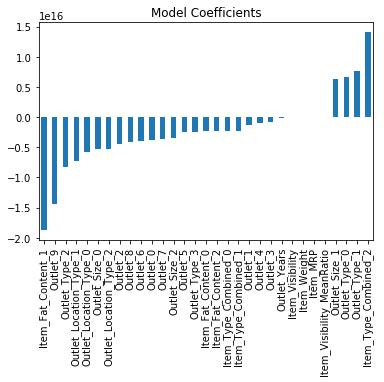

In [97]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target] + IDcol]
print(predictors)
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

#### Ridge Regression Model


Model Report
RMSE : 1129
CV Score : Mean - 0.7471 | Std - 0.01819 | Min - 0.7032 | Max - 0.7828


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


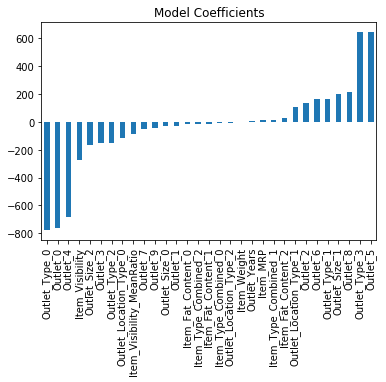

In [98]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

#### Decision Tree Model


Model Report
RMSE : 1058
CV Score : Mean - 0.7657 | Std - 0.02573 | Min - 0.7039 | Max - 0.8193


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


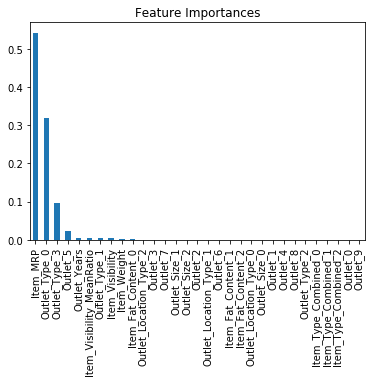

In [99]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

Try another tree with the most significant 4 vars, max_depth of 8 and min_sample_leaf as 150


Model Report
RMSE : 1071
CV Score : Mean - 0.7635 | Std - 0.02464 | Min - 0.7032 | Max - 0.8087


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


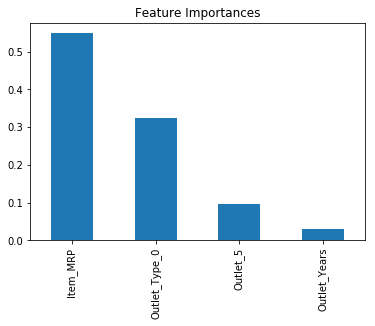

In [100]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

#### Random Forest Model


Model Report
RMSE : 1073
CV Score : Mean - 0.7699 | Std - 0.02205 | Min - 0.7214 | Max - 0.8048


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


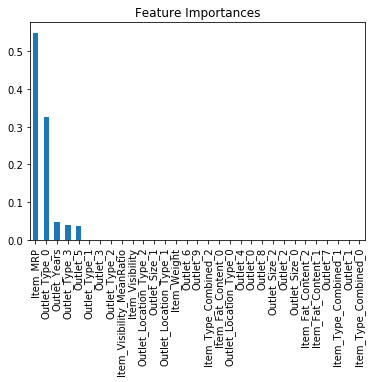

In [101]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

Try another random forest with max_depth of 6 and 400 trees. Increasing the number of trees makes the model robust but is computationally expensive.


Model Report
RMSE : 1068
CV Score : Mean - 0.7704 | Std - 0.02232 | Min - 0.7207 | Max - 0.8065


C:\Users\mengyang.zhang\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


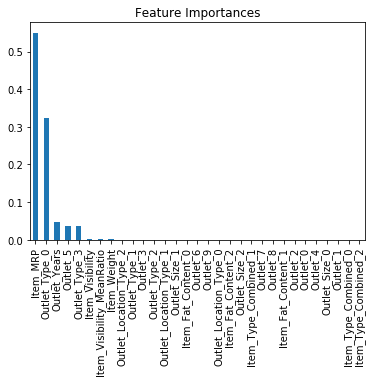

In [102]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')